# Code to test binary classifiers and display metrics

In [1]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Data Loader

In [2]:
# Image preprocessing tranformation
from skimage.filters.rank import enhance_contrast
from skimage import feature, io, img_as_ubyte
from skimage.morphology import disk

def ceed_canny(image):
    im = io.imread(image)
    enh = enhance_contrast(im, disk(1))
    edges = feature.canny(enh)
    final = img_as_ubyte(edges)
    return final

# Custom Lungs Dataset that can be constructed into Train, Test, Validation dataset respectively, and select a Dataset (Normal-Infected or Covid-NonCovid) to use, based on the binary classifier implementation.
class TestLungsDataset(Dataset):
    def __init__(self, group, mode=0, preprocessing=False):

        # Select the mode for Dataset
        if mode not in [0, 1]:
            raise ValueError("Please input a mode as integers: 0: [Normal-Infected], 1: [Covid-NonCovid]")
        self.mode = mode

        self.img_size = (150, 150)
        
        self.class_names = ['normal', 'covid', 'non-covid']
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_non_covid'}
        
        self.groups = [group]
        self.preprocessing = preprocessing
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_non_covid': 2530,\
                                'val_normal': 8,\
                                'val_infected_covid': 9,\
                                'val_infected_non_covid': 8,\
                                'test_normal': 234,\
                                'test_infected_covid': 139,\
                                'test_infected_non_covid': 242}
        
    def get_dataset_path(self, _class):
        sub_path = None
        group = self.groups[0]
        if _class == self.classes[1]:
            sub_path = os.path.join("infected", "covid")
        elif _class == self.classes[2]:
            sub_path = os.path.join("infected", "non-covid")
        else:
            sub_path = "normal"
        return os.path.join("dataset", group, sub_path)

    def filter_dataset_numbers(self):
        filtered_dataset_numbers_map = dict()
        for key, value in self.dataset_numbers.items():
            if self.groups[0] in key:
                filtered_dataset_numbers_map[key] = value
        return filtered_dataset_numbers_map

    def describe(self):
        filtered_dataset_numbers_map = self.filter_dataset_numbers()
        # Generate description
        msg = "This is the Lung {} Dataset used for the Small Project Demo in the 50.039 Deep Learning class".format(self.groups[0].upper())
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(len(self))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for group in self.groups:
            for _class in self.classes.values():
                label = "{}_{}".format(group, _class)
                path = self.get_dataset_path(_class)
                msg += " - {}, in folder {}: {} images.\n".format(label, path, filtered_dataset_numbers_map[label])
        print(msg)
    
    def open_img(self, _class, index):
        group = self.groups[0]
        if _class not in self.classes.values():
            raise ValueError("Input class not found! Please input: {}. Got: {}".format(list(self.classes.values()), _class))
        max_val = self.dataset_numbers['{}_{}'.format(group, _class)]
        if index < 0 or index >= max_val:
            raise ValueError("Index out of range! Should be (0 ~ {}) but got {}".format(max_val-1, index))
        path_to_file = os.path.join(self.get_dataset_path(_class), "{}.jpg".format(index))
        with open(path_to_file, 'rb') as f:
            if self.preprocessing:
                img = torch.from_numpy(ceed_canny(path_to_file))
                img = transforms.ToPILImage()(img)
            else:
                img = Image.open(f)
            image = np.asarray(img) / 255
            image = transforms.functional.to_tensor(np.array(image)).float()
        f.close()
        return image
    
    def show_img(self, _class, index):
        # Open image
        im = self.open_img(_class, index)
        
        # Display
        plt.imshow(im)

    def __len__(self):
        length = 0
        for key, item in self.dataset_numbers.items():
            if self.groups[0] in key:
                length += item
        return length

    def __getitem__(self, index):
        filtered_dataset_numbers_map = self.filter_dataset_numbers()
        first_val = int(list(filtered_dataset_numbers_map.values())[0])
        second_val = int(list(filtered_dataset_numbers_map.values())[1])
        if index < first_val:
            _class = 'normal'
            label = 0
        elif first_val <= index < first_val + second_val:
            _class = 'infected_covid'
            index = index - first_val
            label = 1
        else:
            _class = 'infected_non_covid'
            index = index - first_val - second_val
            label = 2
        imgs = self.open_img(_class, index)
        return imgs, label

## Prepare Test Set

For testing, shuffle has been turned off for consistency.

In [3]:
# Test set
testset = TestLungsDataset(group="val", mode=0, preprocessing=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

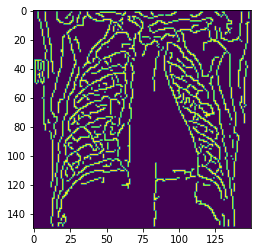

In [4]:
for images, labels in test_loader:
    image = images[20]
    plt.imshow(np.squeeze(image))
    plt.show()

tensor(2)


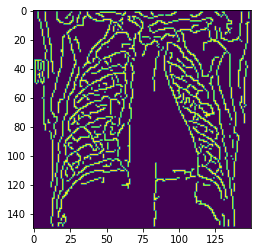

In [5]:
for images, labels in test_loader:
    print(labels[20])
    image = images[20]
    plt.imshow(np.squeeze(image))
    plt.show()

## Load Models

In [6]:
class Model(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()

        self.dropout = dropout
        self.conv2d_2_1 = nn.Conv2d(1, 20, 5)
        self.conv2d_2_2 = nn.Conv2d(20, 50, 5)
        self.maxPool2d_2 = nn.MaxPool2d(kernel_size=3, stride=2, dilation=1)
        self.linear_2_1 = nn.Linear(50 * 33 * 33, 500)
        self.linear_2_4 = nn.Linear(500, 2)
    
        self.dropout = nn.Dropout(self.dropout)
        self.adaptiveAvgPool = nn.AdaptiveAvgPool2d(7)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x:torch.Tensor):
        x = F.relu(self.conv2d_2_1(x))
        x = self.maxPool2d_2(x)
        x = F.relu(self.conv2d_2_2(x))
        x = self.maxPool2d_2(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        # Classifier
        x = F.relu(self.linear_2_1(x))
        x = self.dropout(x)
        x = F.relu(self.linear_2_4(x))
        x = self.softmax(x)
        return x

In [7]:
first_model_name = "small_project_model_binary_ni_preprocessed_1.pth"
second_model_name = "small_project_model_binary_cn_preprocessed_1.pth"

first_model = Model()
second_model = Model()

if os.path.exists(first_model_name):
    first_model.load_state_dict(torch.load(first_model_name))
    
if os.path.exists(second_model_name):
    second_model.load_state_dict(torch.load(second_model_name))
    
print(first_model)
print(second_model)

Model(
  (conv2d_2_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2d_2_2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (maxPool2d_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_2_1): Linear(in_features=54450, out_features=500, bias=True)
  (linear_2_4): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (adaptiveAvgPool): AdaptiveAvgPool2d(output_size=7)
  (softmax): Softmax(dim=1)
)
Model(
  (conv2d_2_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2d_2_2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (maxPool2d_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_2_1): Linear(in_features=54450, out_features=500, bias=True)
  (linear_2_4): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (adaptiveAvgPool): AdaptiveAvgPool2d(output_size=7)
  (softmax): Softmax(dim=1)
)


## Helper Functions to Visualize

In [8]:
def show_images(images, labels, preds):
    class_names = test_loader.dataset.class_names
    plt.figure(figsize=(16, 8))
    for i, image in enumerate(images):
        plt.subplot(5, 5, i + 1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(image))
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.rc('axes', labelsize=14)
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

def show_preds(model):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.to("cuda")
    labels = labels.to("cuda")
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

## Testing

In [9]:
criterion = torch.nn.CrossEntropyLoss()

num_of_tests = len(test_loader.dataset)

# 3-classes labelled final results for metrics computation
predictions = [0 for _ in range(num_of_tests)]
ground_truths = [0 for _ in range(num_of_tests)]

first_model, second_model = first_model.cuda(), second_model.cuda()

first_model.eval()
second_model.eval()
inputs = None

images, labels = next(iter(test_loader))
ground_truths = labels.numpy()
images = images.to("cuda")
labels = labels.to("cuda")
outputs = first_model(images)
_, preds = torch.max(outputs, dim=1)

for i, pred in enumerate(preds):
    if pred == 0:
        predictions[i] = 0
    else:
        output = second_model(images[i][None, ...])
        _, pred = torch.max(output, dim=1)
        if pred == 0:
            predictions[i] = 1
        else:
            predictions[i] = 2

print(predictions)
print(ground_truths)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]


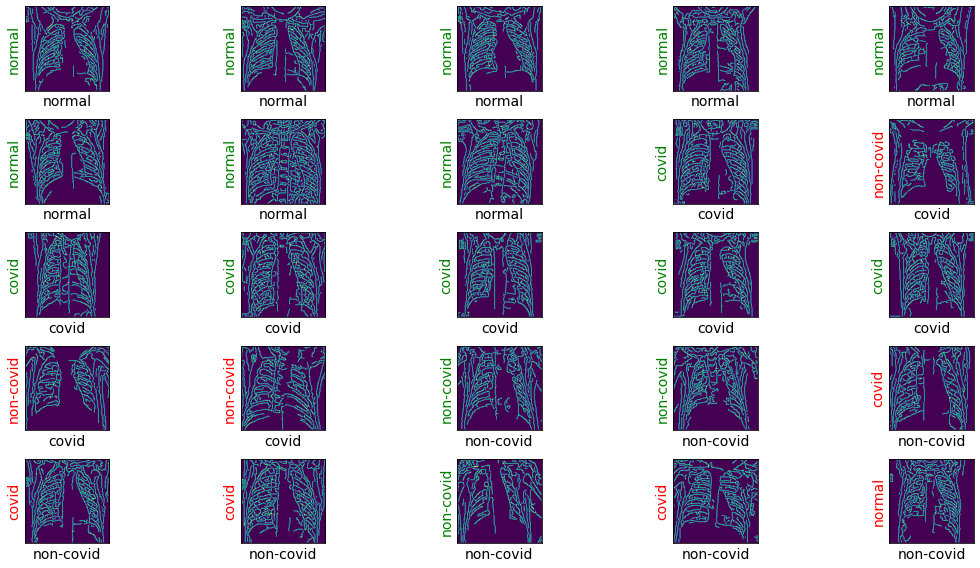

In [14]:
class_names = ["normal", "covid", "non-covid"]
plt.figure(figsize=(16, 8))
for i, image in enumerate(images.cpu()):
    plt.subplot(5, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(image))
    col = 'green'
    if predictions[i] != ground_truths[i]:
        col = 'red'
    plt.rc('axes', labelsize=14)
    plt.xlabel(f'{class_names[int(ground_truths[i])]}')
    plt.ylabel(f'{class_names[int(predictions[i])]}', color=col)
plt.tight_layout()
plt.show()

# Results Presentation

- F1 Score
- Precision
- Recall
- Accuracy
- Confusion Matrix

In [10]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Normal, Covid, Non-Covid Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F1: 0.665688
Precision: 0.660444
Recall: 0.680000
Accuracy: 0.680
Confusion matrix, without normalization
[[8 0 0]
 [0 6 3]
 [1 4 3]]


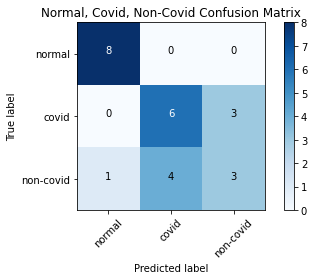

In [11]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

cm = confusion_matrix(np.array(ground_truths), np.array(predictions))
print("F1: {:.6f}".format(f1_score(np.array(ground_truths), np.array(predictions), average="weighted")))
print("Precision: {:.6f}".format(precision_score(np.array(ground_truths), np.array(predictions), average="weighted")))
print("Recall: {:.6f}".format(recall_score(np.array(ground_truths), np.array(predictions), average="weighted")))
print("Accuracy: {:.3f}".format(accuracy_score(np.array(ground_truths), np.array(predictions))))
plot_confusion_matrix(cm, test_loader.dataset.class_names)